# DSCI 100-002 Project Final Report: Predicting Playing Time on MineCraft Based on Age and Player Experience
---

**Date:** April 5th, 2025

**Group 32:** Christine Choi, Austin Hart, Katherine Hsu, Jack Yan

## Introduction
---

### Background
Minecraft, a sandbox video game developed by Mojang Studios and released in 2011, has become a global phenomenon, engaging millions of players across all age groups on its versatile platform. One key metric of engagement is the total hours players spend in the game, which can vary widely depending on individual player characteristics. For our research, we used data that was provided by plaicraft.ai, which is led by The Pacific Laboratory for Artificial Intelligence (PLAI), a research group from the Department of Computer Science at the University of British Columbia. 

### Research question
One of the broad questions that the research group was interested in is knowing which "kinds" of players are most likely to contribute a large amount of data in order to target these players in their recruiting efforts. Specifically, the question we wanted to explore was:

Can `Age` and `experience` predict `played_hours` in `players.csv`?

We chose the number of hours played as an outcome variable under the assumption that the more time someone spends playing on the Minecraft server, the more their engagement is going to contribute to the research project data. Moreover, we chose to look at age and experience as predictor variables because the combination of these two participant factors could help the researchers get a rough idea of the general audience to target in recruitment (e.g. teenagers that regularly play MineCraft).

### Description of dataset
The dataset that we used in this project is `players.csv`, which contains a total of 196 observations (i.e. information about 196 unique players). There are 7 variables which include:
- `experience` (character) - player's level of experience in the game (Beginner, Amateur, Regular, Pro, Veteran)
- `subscribe` (logical) - TRUE if player is subscribed to a game-related newsletter, FALSE if they are not subscribed
- `hashedEmail` (character) - player's email address scrambled into a unique code
- `played_hours` (double) - number of hours (to one decimal place) that the player has played the game
- `name` (character) - first name of the player
- `gender` (character) - player's gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-spirited, Other)
- `Age` (double) - player's age as a number

For the purpose of our research question, the relevant columns are `Age`, `experience`, and `played_hours`. In the survey where the user fills out their personal information, those below the age of 7 are unable to participate and the maximum age that someone can input is 99. Furthermore, level of experience was defined as:

1) Beginner - I'm completely new to Minecraft
2) Amateur - I've played a few hours of Minecraft
3) Regular - I regularly play Minecraft
4) Pro - I am an experienced and pro Minecraft player
5) Veteran - Been here since the old days. (Before 2015)

Some visible issues in the data file include:
- Values in the `Age` column containing "NA" instead of a number which could be an issue for applying computations since not all values in the column are the same data type.
- `experience` and `gender` having character data types which should be converted to factors since they are both categorical variables with distinct values.

Other potential issues that we noticed include:
- Values in the `hashedEmail` column differing in length and including both numbers and letters, which could present a challenge for functions requiring indexing.
- Each observation in `hashedEmail`being a unique code which could present challenges for filtering by this variable.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(2020)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading the data

In [2]:
players <- read_csv('players.csv')
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Tidying & Wrangling

The `players_tidy` data frame was created by removing missing values from the full dataset using `na.omit()`. For the purposes of calculating on a regression model, the `experience` variable was then transformed from character type (e.g., "Beginner", "Pro", etc.) to numeric values ranging from 1 to 5. The numbers were assigned in the following manner: 1 for Beginner, 2 for Amateur, 3 for Regular, 4 for Pro, and 5 for Veteran. Finally, only three relevant columns — `experience`, `Age`, and `played_hours` — were selected for further analysis. Due to the large number of players who had 0 hours of recorded play time, the hours were converted to minutes for a more meaningful data visualization and analysis. This step ensured that the dataset was clean and structured for meaningful exploration.

In [3]:
players_tidy <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Pro" ~ 4,
      experience == "Veteran" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    select(experience, Age, played_minutes)
head(players_tidy)

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
4,9,1818
5,17,228
5,17,0
2,21,42
3,21,6
2,17,0


## Summary Statistics
---

### Special cases
- Players with 100 or more hours of playtime = 4
- Players with 0 hours of playtime = 85

In [4]:
players_with_zero <- players_tidy |>
    filter(played_minutes == 0) |>
    count()
as.numeric(players_with_zero)

[1] 85

In [5]:
players_over100 <- players_tidy |>
    filter(played_minutes > 6000) |>
    count()
as.numeric(players_over100)

[1] 4

### Average minutes played
- Beginner = 74.91
- Amateur = 361.05
- Regular = 1123.54
- Pro = 167.08
- Veteran = 38.88
  
The `experience_playtime_means` table was generated by grouping `players_tidy` by `experience` and calculating the average `played_hours` (converted to minutes) for each level. The results indicated that Regular players have the highest mean playtime (1123.54 minutes), while Veterans have the lowest (38.88 minutes). This suggests that mid-tier players might be more engaged in the project server compared to beginners and highly skilled players.

In [6]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_minutes = mean(played_minutes))
experience_playtime_means

experience,mean_player_minutes
<dbl>,<dbl>
1,74.91429
2,361.04762
3,1123.54286
4,167.07692
5,38.87500


### Age with the most amount of play time
- 16 years old (average minutes played = 3002.00)

In [7]:
age_playtime_means <- players_tidy |>
    group_by(Age) |>
    summarize(mean_player_minutes = mean(played_minutes))
age_playtime_means

Age,mean_player_minutes
<dbl>,<dbl>
8,18.00000
9,1818.00000
10,216.00000
11,174.00000
12,30.00000
14,522.00000
15,6.00000
16,3002.00000
17,285.44000


### Average age
- Beginner = 21.66
- Amateur = 20.25
- Regular = 20.60
- Pro = 16.92
- Veteran = 20.96

The `experience_age_means` data frame was created by grouping `players_tidy` by `experience` and computing the average `Age` for each level. The findings show that more experienced players tend to be younger, with Pro players averaging 16.92 years old. In contrast, Beginners have the highest mean age at 21.66 years. This may indicate that younger players reach higher skill levels faster.

In [8]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<dbl>,<dbl>
1,21.65714
2,20.25397
3,20.60000
4,16.92308
5,20.95833


## Exploratory Data Visualization
---

### Figure 1. Average playtime by experience level

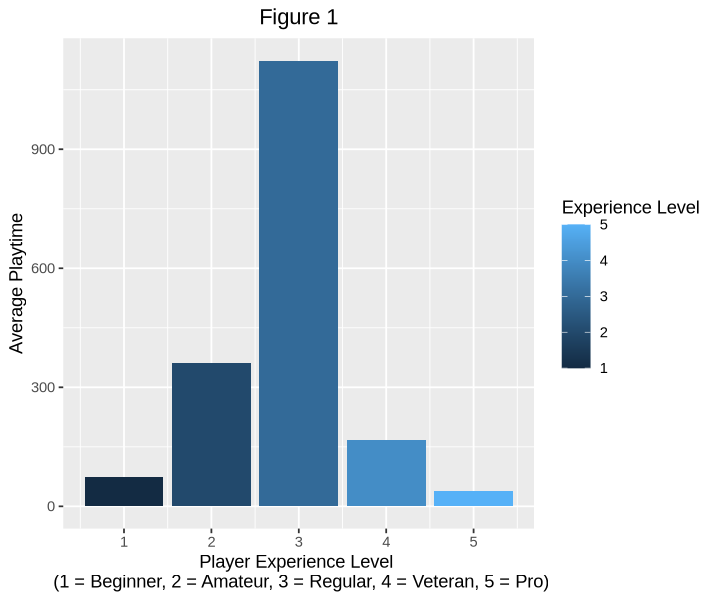

In [9]:
options(repr.plot.width = 6, repr.plot.height = 5)

experience_playtime_plot <- ggplot(experience_playtime_means, aes(x = experience, y = mean_player_minutes, fill = experience)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Experience Level \n (1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro)', 
         y = 'Average Playtime', 
         title = 'Figure 1', 
         fill = 'Experience Level') +
    theme(plot.title = element_text(hjust = 0.5))
experience_playtime_plot

### Figure 2. Average playtime by age
We found that ages between 17 and 21 played the most. There is a peak near age 50 due to the fact that there was only one reported instance of a 50 year old player, hence that data is being represented by that one player.

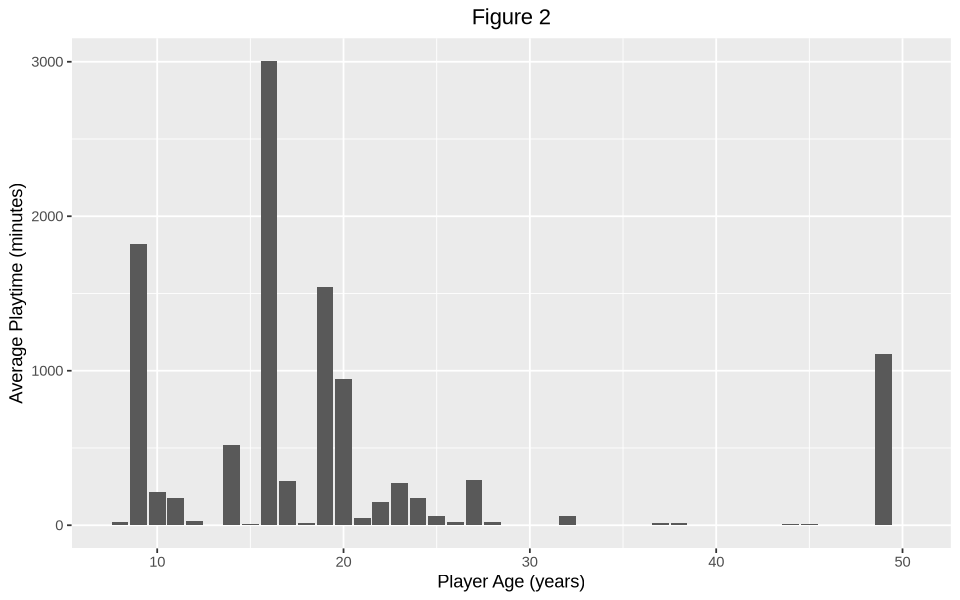

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)

age_playtime_plot <- ggplot(age_playtime_means, aes(x = Age, y = mean_player_minutes)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Age (years)', y = 'Average Playtime (minutes)', title = 'Figure 2') +
    theme(plot.title = element_text(hjust = 0.5))
age_playtime_plot

### Figure 3. Average player age by experience
In visualizing the average age for each experience type, we found that most were close to their early 20s, with those that identified as “Pros” were in their teens. 

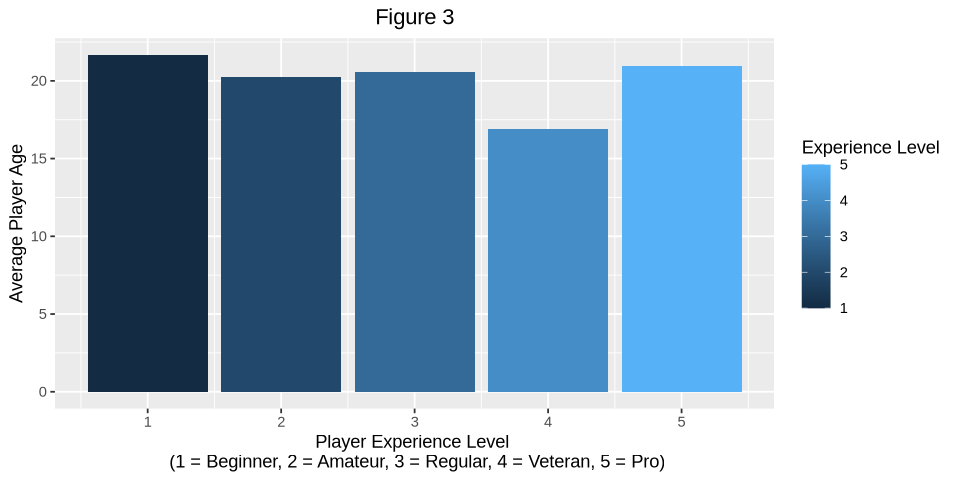

In [11]:
options(repr.plot.width = 8, repr.plot.height = 4)

experience_age_plot <- ggplot(experience_age_means, aes(x = experience, y = mean_age, fill = experience)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Player Experience Level \n (1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro)', 
         y = 'Average Player Age', title = 'Figure 3', fill = 'Experience Level') + 
    theme(plot.title = element_text(hjust = 0.5))
experience_age_plot

## Methods
---
The method we used to analyze the amount of hours played is K-nearest neighbor (KNN) regression. Since both the predictor (the players’ age) and predicted (hours played) are quantitative variables, regression was the most appropriate in terms of prediction models. With the experience type, we were able to convert the various categories by labelling them with numbers (e.g. Beginner = 1, Amateur = 2, etc.). Furthermore, considering the trend observed in the exploratory visualization appears to be slightly curvilinear (figures 1 and 2), we decided to use k-nearest neighbour rather than linear regression since it is not limited by non-linear data.

### Data splitting
The dataset `players_tidy` was split into training (75%) and testing (25%) sets using stratified sampling based on `played_hours`. A preprocessing recipe was created for the training data, where `experience` and `Age` were standardized using `step_scale()` and `step_center()`. These steps ensured that predictors were on a similar scale, preventing bias in the model due to differing units or magnitudes.

### Model Specification, Cross-Validation, and Workflow Construction
A K-nearest neighbours (KNN) regression model was defined with neighbours as a tunable parameter and `weight_func` set to "rectangular". Next, five-fold cross-validation was applied to the training set using `vfold_cv()` and stratified by `played_hours` to ensure balanced sampling. This approach helped assess model performance across different data subsets while reducing overfitting. A machine learning workflow was then created by integrating the preprocessing recipe and KNN model specification. The `players_workflow` object streamlined data preprocessing and model training, making it ready for hyperparameter tuning and accurate prediction of `played_hours` based on `experience` and `Age`.

### Tuning the model
We tuned the model by testing multiple potential values of k and finding which value resulted in the lowest RMSPE value. Due to the abundance of players with zero or close to zero hours played, this method of choosing k resulted in the highest possible value of k being chosen, resulting in a nearly flat prediction line. This is a problem because it results in a useless prediction model that is completely insensitive to changes in age or experience level, predicting near-zero playtime for any player. We found that before reaching its absolute minimum, RMSPE reached a local minimum of nearly the same value. Thus, we decided to use the k value that resulted in a local minimum for our model, sacrificing a bit of accuracy to create a more useful model.

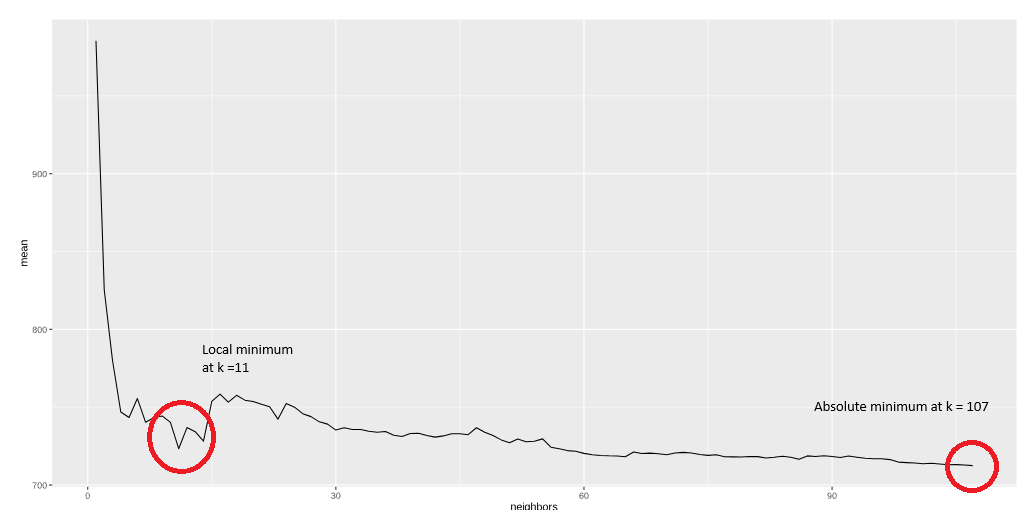

### Excluding outliers
We decided to create a second prediction model that excludes outliers. A small group of players played more than 100 hours, setting them well apart from all the other players in the data set. By removing these outliers (i.e. those who played more than 100 hours (6000 minutes)), we hoped to make a prediction model that was more sensitive to smaller differences in playtime.

### Visualization design choice
We decided to present our graphs using `facet_wrap()` to present a separate graph with age on the x-axis and playtime on the y-axis for each of the five experience levels. This was the best way to present our three-dimensional calculations on a two-dimensional graph. 

### Figure 4. Tuning plot (including outliers)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,rmse,standard,723.3331,5,262.1619,Preprocessor1_Model11


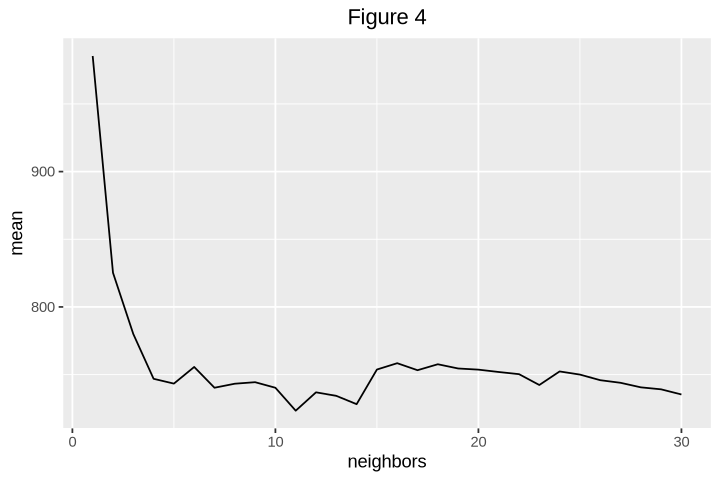

In [12]:
set.seed(2020)

options(repr.plot.width = 6, repr.plot.height = 4)
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_minutes)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(played_minutes ~ experience + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_minutes)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min
tuneplot <- ggplot(players_results, aes(x = neighbors, y = mean)) +
    geom_line() +
    ggtitle('Figure 4') +
    theme(plot.title = element_text(hjust = 0.5))
tuneplot

### RMSE (including outliers)

In [13]:
set.seed(2020)

players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 11) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3087.87


### Figure 5. Prediction model plot (including outliers)

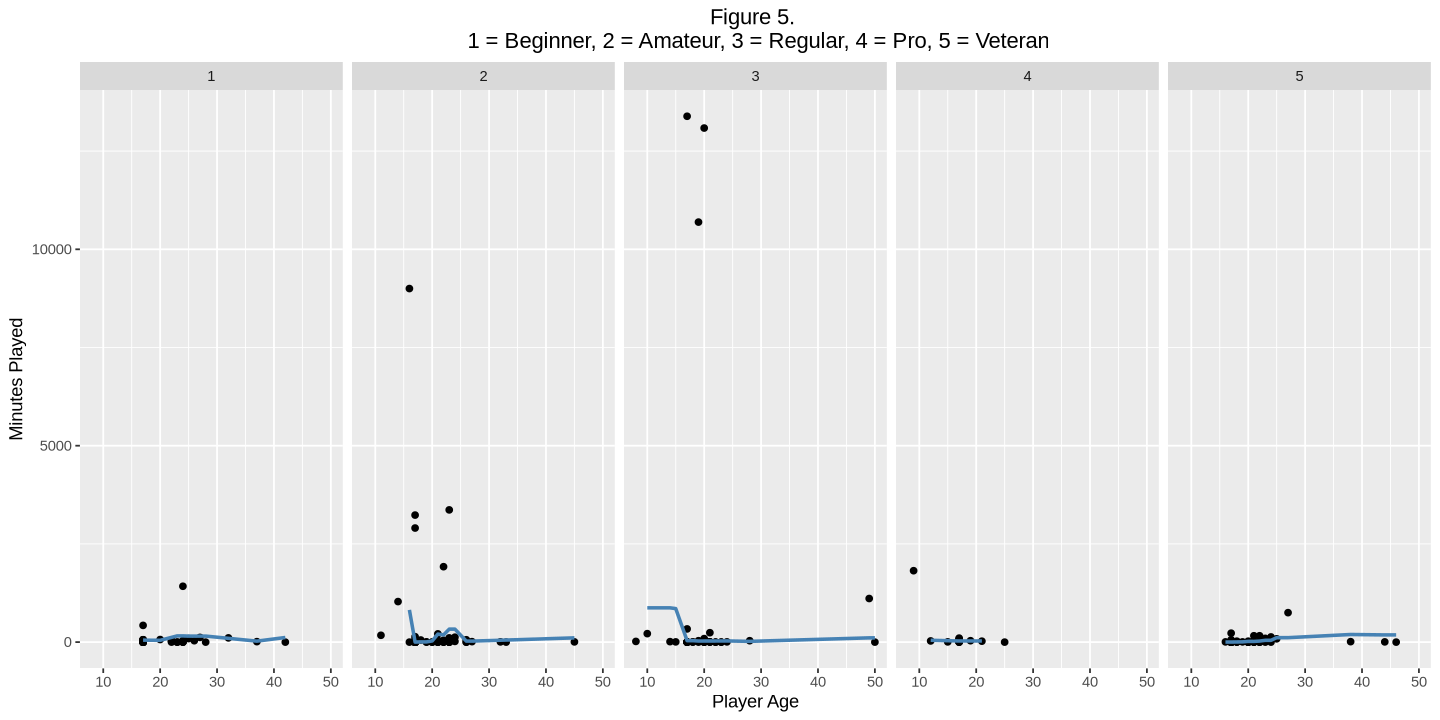

In [14]:
set.seed(2020)

options(repr.plot.width = 12, repr.plot.height = 6)
players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('Figure 5. \n 1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Pro, 5 = Veteran') +
    theme(plot.title = element_text(hjust = 0.5))

players_plot + facet_wrap(~experience, ncol = 5)

### Excluding outliers

In [15]:
players_no_outliers <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Pro" ~ 4,
      experience == "Veteran" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    filter(6000 > played_minutes) |>
    select(experience, Age, played_minutes)
head(players_no_outliers)

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
4,9,1818
5,17,228
5,17,0
2,21,42
3,21,6
2,17,0


### Figure 6. Tuning plot (excluding outliers)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,463.493,5,128.2652,Preprocessor1_Model04


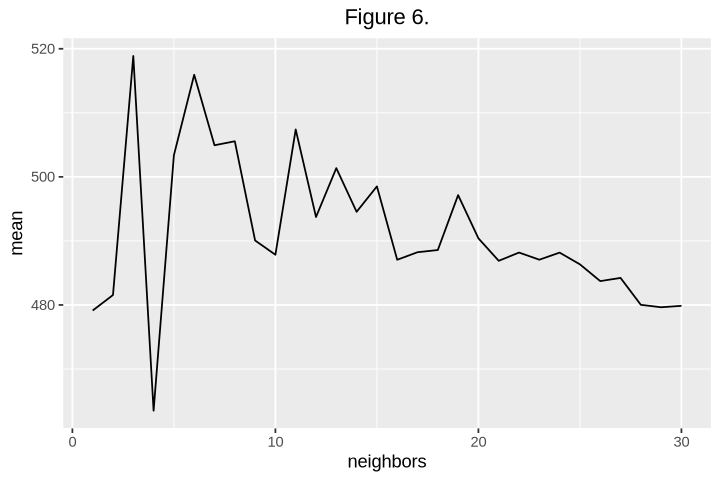

In [16]:
set.seed(2020)

options(repr.plot.width = 6, repr.plot.height = 4)
players_split2 <- initial_split(players_no_outliers, prop = 0.75, strata = played_minutes)
players_train2 <- training(players_split2)
players_test2 <- testing(players_split2)

players_recipe2 <- recipe(played_minutes ~ experience + Age, data = players_train2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold2 = vfold_cv(players_train2, v = 5, strata = played_minutes)

players_workflow2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec_tune2)

gridvals2 <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

players_results2 <- players_workflow2 |>
  tune_grid(resamples = players_vfold2, grid = gridvals2) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min2 <- players_results2 |>
    filter(mean == min(mean))
players_min2

tuneplot2 <- ggplot(players_results2, aes(x = neighbors, y = mean)) +
    geom_line() +
    ggtitle('Figure 6.') +
    theme(plot.title = element_text(hjust = 0.5))
tuneplot2

### RMSE (excluding outliers)

In [17]:
set.seed(2020)

players_spec2 <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 4) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec2) |>
    fit(data = players_train2)

players_summary2 <- players_fit2 |>
  predict(players_test2) |>
  bind_cols(players_test2) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,274.1579


### Figure 7. Prediction model plot (excluding outliers)

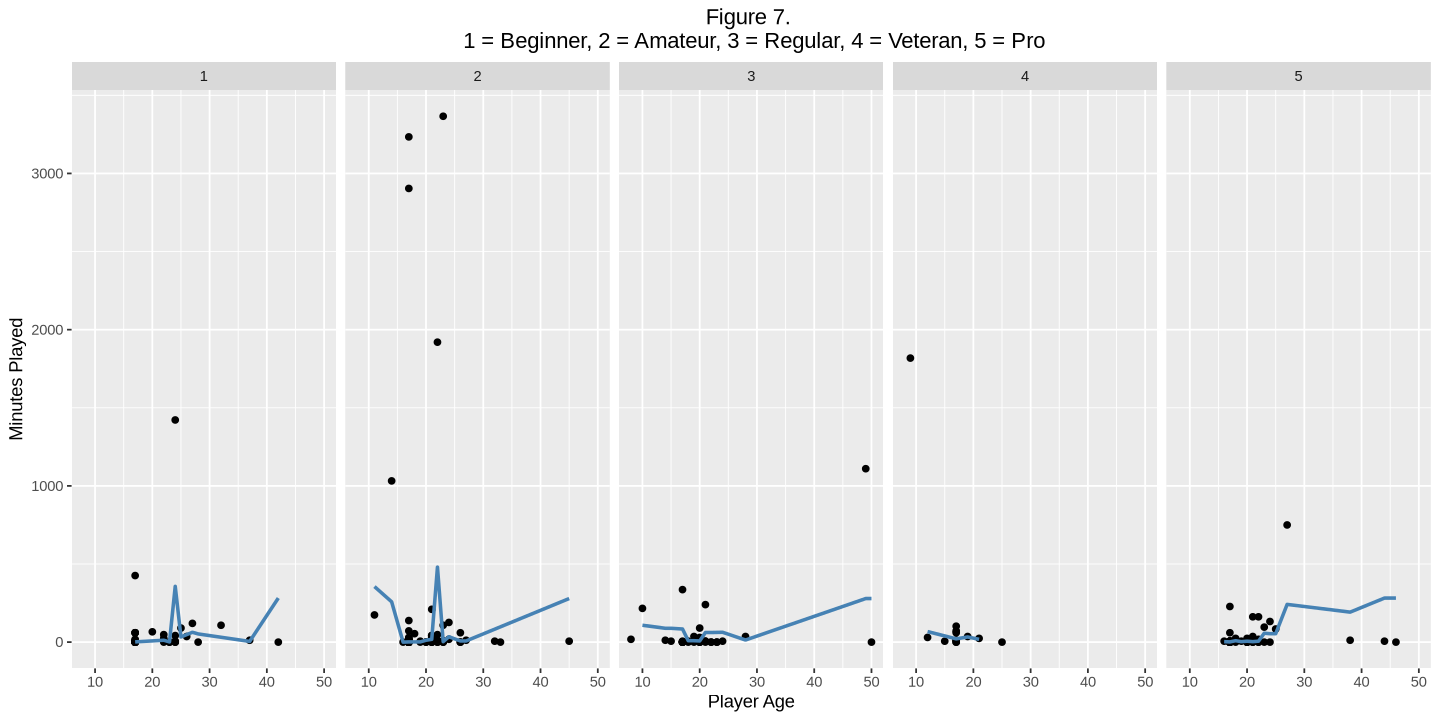

In [18]:
set.seed(2020)

options(repr.plot.width = 12, repr.plot.height = 6)
players_preds2 <- predict(players_fit2, players_train2) |>
        bind_cols(players_train2)

players_plot2 <- ggplot(players_no_outliers, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds2,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('Figure 7. \n 1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro') +
    theme(plot.title = element_text(hjust = 0.5))
players_plot2 + facet_wrap(~experience, ncol = 5)

## Summary of Results
---

### Dataset and Processing
- Initial dataset contained 196 observations; 194 rows remained after removing NA values.
- Experience re-coded as numerical values: 1 (Beginner) to 5 (Veteran).
- Played hours converted to minutes and outliers (≥6000 minutes) filtered out.

### Outliers
- All outliers (≥6000 minutes) fell under the "Regular" category (experience = 3).
- Specific outliers: Players around age 20 with >200 hours (12,000 minutes).

### Exploratory Insights
- Playtime peaks: age 9 (1818 minutes) and age 16 (3002 minutes).
- Mean age by experience: ~17–22 years; "Regular" likely skewed by outliers.

### Modeling Results
- KNN regression predicted played minutes based on age and experience with a minimum RMSE ~722 minutes (11 neighbors) excluding outliers.
- Impact of outliers on RMSE: ~3088 minutes with outliers and ~274 minutes without outliers (significant drop).

### Prediction example
- Our model predicts a new player with experience = 5 and age = 10 would play approximately 5 minutes.

In [19]:
new_player <- tibble(experience = 5, Age = 10, played_hours = 0.0)
new_predictions <- players_fit |>
    predict(new_player) |>
    bind_cols(new_player)
new_predictions

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
4.909091,5,10,0


## Discussion
---

### Hypothesis vs. what we found
We originally expected that higher experience and younger ages would have higher playtimes and that the outliers were contributing to skewing or conflating the data points such that removing them would lower the RMSE. 

Unexpectedly, we found that the “regular” group of players fit a broad, sporadic player group and contributed to the data most, which did not align with our hypothesis. However, removing the outliers did result in improving the model slightly, as it showed that it was more sensitive to the variability of the play times, although there were still outliers within the smaller data set, which limited the overall accuracy of the model. 

Overall, we concluded that within the entire data set, age and experience may not be the most accurate predictors considering that the prediction model’s RMSPE was still quite large despite removing outliers (decreased from 3088 minutes with outliers to 274 minutes without outliers). 

### Limitations
Some of the challenges that we encountered with this data set was that it may not be representative of each type of player. For example, there was only one 9-year-old player and one 50-year-old player, which makes these age groups not represented fairly compared to those in the late teens or early 20s. Additionally, it was mentioned before that 85 players had zero minutes of playtime, which is one of the things that led to the prediction model’s high RMSPE (due to the large gap between these players and the outliers). Consequently, the prediction line remained mostly stagnant near the zero minutes of played.

The data collection method itself may also have varying interpretations by different players. More specifically, the “experience type” may be up to interpretation, hence the reason why there are more players who identify as “regulars” than “pros". Players who identify as "regulars" likely tend to have the highest playtime because they interpreted this designation not as a measure of experience but a measure of current habits (i.e. they planned to play "regularly" in the future). Similarly, players who identified as "veterans" likely did so because they consider themselves former players who no longer play as frequently, resulting in this category having the lowest average playtime. Our model assumes these distinct experience categories have a consistent linear relationship. 

### Impact of findings & future directions
There were three broad categories our findings could have an impact: game development and marketing, modeling, and player behavior insights. 

**Game Development and Marketing:**

- "Regular" outliers and age ~20 focus: Target semi-committed young adults with high playtime potential.
- Young player peaks (ages 9, 16): Design features for active younger audiences.

**Modeling and Analytics:**
- RMSE drop (2814 minute difference): Validates outlier removal, but persistent skewness calls for robust methods (e.g., median-based metrics).
- Zero-playtime prevalence: Differentiate active vs. inactive users for accurate engagement metrics.

**Player Behavior Insights:**
- High playtime outliers (>200 hours): Highlight dedicated players for engagement or monetization strategies.
- Skewed data: Challenges standardization, reducing playtime prediction reliability.

**Broader Implications:**
- Parental tools: Age-based playtime insights could inform time-management features.
- Research needs: Self-reported data subjectivity (e.g., "Veteran") suggests validation methods.
- External Factors: What drives high playtime at specific ages (e.g., school breaks, game type)?
- Additonally, the researchers could consider making the survey options for different types of experiences more specific so it is less likely to be interpreted differently by each person.

## References
---

Wikimedia Foundation. (2025, April 2). Minecraft. Wikipedia. https://en.wikipedia.org/wiki/Minecraft#:~:text=Minecraft%20is%20a%202011%20sandbox,released%20on%2017%20May%202009. 

Home Page. Pacific Laboratory for Artificial Intelligence. (2024a, December 5). https://plai.cs.ubc.ca/ 